# Introduction to machine learning in molecular chemistry

Machine learning (ML) is an important tool for novel drug design. Using mathematical models to select molecules for laboratory testing allows pharma companies to save time and money, and shorten time-to-market for new drugs.

This tutorial is a short introduction to molecular property prediction, a key area in novel drug design. The goal is to create a predictive model that is able to accurately predict certain properties of molecules, based on historical experimental data. Such properties include, e.g., bioactivity, toxicity, or solubility.

## Data loading

We provided files for another dataset that we authored, [ApisTox](https://www.nature.com/articles/s41597-024-04232-w). It concerns predicting toxicity of pesticides to honey bees. The procedure is exactly the same - pesticides are represented as SMILES, should be parsed as molecules, and the task is binary classification (toxic/non-toxic).

Let's load the data and see an example entry.

In [3]:
import pandas as pd

apistox = pd.read_csv('data/apistox_full.csv')

smiles_apistox = apistox["SMILES"]
y_apistox = apistox["label"]

print(smiles_apistox[1])
print(y_apistox[1])

Cc1ccc(C(C)C)cc1
0


SMILES is the standard format for storing molecules as text. To work with this data, we need to parse it as **molecular graphs**, i.e. load the actual atoms, bonds, and the compound structure. We use the [RDKit library](https://www.rdkit.org/docs/GettingStartedInPython.html) for that. Then, we can also visualize it.

Based on those structures, we need to learn the structure-label relationship with machine learning. Then, for new molecules, we want to predict the label. This is based on the idea of **molecular similarity principle** - structurally alike compounds should have similar properties.

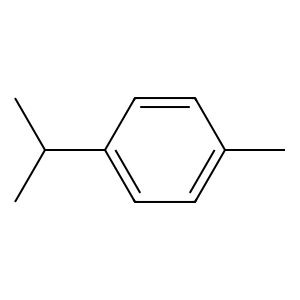

In [4]:
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import MolToImage

mol = MolFromSmiles(smiles_apistox[1])

print(mol)

MolToImage(mol)

Now to do this for all molecules, we can use the list comprehension, as shown below. However, scikit-fingerprints offers an easier way, which we will explore below.

RKit prints a lot of warnings about hydrogens - this can be safely ignored.

In [5]:
mols_apistox = [MolFromSmiles(smiles) for smiles in smiles_apistox]

### Scikit-fingerprints API

Scikit-fingerprints is based on the scikit-learn interface (API), which primarily means:

1. Many elements (e.g. molecular fingerprints, filters) are represented as Python classes.
2. Constructor parameters control the general behavior, and act as hyperparameters in ML.
3. Primary methods are:
   - `.fit()` - learn from data, e.g. train model
   - `.transform()` - transform data, e.g. turn molecules into feature vectors
   - `.predict()` - predict for new data using trained model
4. It's fully interoperable with scikit-learn and other libraries in that ecosystem.

In scikit-fingerprints, we primarily use the `.transform()` interface to process molecules. For example, you can:
- parse SMILES as `Mol` objects
- extract features from molecules, turning `Mol` into NumPy arrays
- combine multiple vector representations
- tune hyperparameters of this process

---

Many drugs directly affect the central nervous system and brain. They need to go through the blood-brain barrier, known as BBBP property. The [BBBP dataset](https://pubs.acs.org/doi/10.1021/ci300124c), published as part of [MoleculeNet benchmark](https://pubs.rsc.org/en/content/articlelanding/2018/sc/c7sc02664a). Historical data is based on laboratory tests on molecules, but for new ones, we can build ML models to predict that _in silico_.

This dataset is built into our [scikit-fingerprints](https://scikit-fingerprints.readthedocs.io/latest/index.html) library, which we will be using for majority of the tutorial. Dataset loading functions follow scikit-learn conventions, and here we will use the [load_bbbp() function](https://scikit-fingerprints.readthedocs.io/latest/modules/datasets/generated/skfp.datasets.moleculenet.load_bbbp.html).

It returns two values:
- list of molecules in SMILES format
- labels (here 0/1, permeates blood-brain barrier or not)

**Exercise 1**

1. Load smiles strings and labels of the bbbp dataset using `load_bbbp()` function from scikit-fingerprints. Store SMILES strings as `smiles_list` and labels as `y_bbbp`
2. Import relevant class from [skfp.preprocessing module](https://scikit-fingerprints.readthedocs.io/stable/modules/preprocessing.html), using the documentation.
3. Create the object instance. You don't need to provide any arguments, but we often use `suppress_warnings`.
4. Pass the SMILES list to `.transform()` method. It returns a list of `Mol` objects. Store the resulting list in `mols` variable.
5. Display an example molecule.


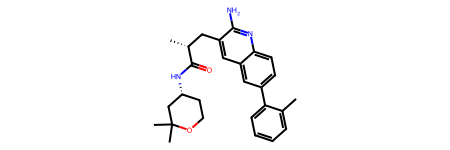

In [15]:
import pandas as pd

# TODO

smiles_list, y_bbbp = ...
mols = ...


Great. We have an expressive molecular representation that can be processed by algorithms.

But now, how do we build a model, and make sure that it will work well on new molecules?

---

### Split the data

To ensure generalization of the model we're going to create, we want to separate part of the data that we won't use to train the model. We'll only use it to evaluate.

We'll pretend that these molecules are "new". This kind of splitting is a crucial step in building and validating an ML model.

Normally in ML, splitting is performed like this:

In [16]:
from sklearn.model_selection import train_test_split
import numpy as np

train_idxs, test_idxs = train_test_split(range(len(smiles_list)), test_size=0.2)

mols_train = np.array(mols)[train_idxs]
mols_test = np.array(mols)[test_idxs]

y_train = y_bbbp[train_idxs]
y_test = y_bbbp[test_idxs]

print(f"Train set size: {len(mols_train)}")
print(f"Test set size: {len(mols_test)}")

Train set size: 1210
Test set size: 303


We created two lists of molecules, and two lists of labels

`mols_train` and `y_train` will be used for training. `mols_test` and `y_test` will only be used for evaluation.

---

### BUT!

We can't do a random split in chemoinformatics. It might not give us a good insight into model's performance. New molecules often come from much different distribution than data that is used for training.

To simulate that, we want the data in train and test dataset, to have different internal structure - scaffold.

scikit-fingerprints implement a split based on the molecular scaffold.

**Exercise 2.**
- From `model_selection` module of scikit-fingerprints import `scaffold_train_test_split` function.
- Call the function on `mols` list of molecules that we created before. use the `test_size` of `0.2`.
- Make sure to set `return_indices` argument to `True` - this way, the function will return two lists of indices for training and testing.
- Use these newly created list to index the data like in the previous example.

In [17]:
from skfp.model_selection import scaffold_train_test_split

train_idxs, test_idxs = scaffold_train_test_split(
    mols, test_size=0.2, return_indices=True
)

# split mols and labels
mols_train = np.array(mols)[train_idxs]
mols_test = np.array(mols)[test_idxs]

y_train = y_bbbp[train_idxs]
y_test = y_bbbp[test_idxs]

print(f"Train set size: {len(mols_train)}")
print(f"Test set size: {len(mols_test)}")

Train set size: 1210
Test set size: 303


### Molecular fingerprints

Molecular fingerprints are algorithms that transform molecular graphs to vector representations, by extracting meaningful features from the graph.

Most popular predictive models work on fixed-size vectors. Graphs are non-euclidean, permutation-invariant and variable-size structures so they can't be directly represented as such.

Molecular fingerprints allow us to create vector representation for molecular graphs by encoding some information about them.

Here we show a use of an example molecular fingerprint - MACCS Keys.

In [19]:
from skfp.fingerprints import MACCSFingerprint

# create fingerprint transformer object
maccs_fp = MACCSFingerprint(n_jobs=-1)

# transform molecules into feature vectors
X_train_maccs = maccs_fp.transform(mols_train)
X_test_maccs = maccs_fp.transform(mols_test)

print(f"Fingerprint data shape: {X_train_maccs.shape}")
print(f"Example vector: {X_train_maccs[0]}")

Fingerprint data shape: (1210, 166)
Example vector: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 1
 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0
 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0]


Now, each of our molecules is represented as a vector of constant size 166.

---

### ECFP

In further code we will use an Extended Connectivity fingerprint (ECFP)

---

---

# TODO - opisać

---

---

**Exercise 3.**
- Just liek in previous example, import the ECFPFingerprint.
- Create the fingerpirnt object instance.
    - Set `count` argument to `True`
    - Set `fp_size` to 1024
    - Set `n_jobs` to `-1` for parallel processing
- Transform the `mols_train` and `mols_test` to `ecfp_train` and `ecfp_test`
    - In case of problems, remember that you performed a similar transformation before, using `MolFromSmiles`

In [20]:
from skfp.fingerprints import ECFPFingerprint

# create fingerprint transformer object
ecfp_fp = ECFPFingerprint(radius=3, count=True, fp_size=1024, n_jobs=-1)

# transform molecules into feature vectors
ecfp_train = ecfp_fp.transform(mols_train)
ecfp_test = ecfp_fp.transform(mols_test)

print(f"Fingerprint data shape: {ecfp_train.shape}")
print(f"Example vector: {ecfp_test[0]}")

Fingerprint data shape: (1210, 1024)
Example vector: [0 1 0 ... 0 0 0]


Now yor data is ready for training!

---

### Train the model

Here we show how to train the random forest model using molecules transformed with ECFP, and compute the AUROC metric in order to evaluate the performance on test data.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from skfp.metrics import multioutput_auroc_score

clf = RandomForestClassifier(n_jobs=-1, random_state=0)
clf.fit(ecfp_train, y_train)

# We want to extract class probability
y_pred = clf.predict_proba(ecfp_test)[:, 1]

auroc = roc_auc_score(y_test, y_pred)

print(f"ECFP AUROC for Random Forest: {auroc:.2%}")

ECFP AUROC for Random Forest: 76.87%


---

### Distances

scikit-fingerprints allows us to compute distances between molecules and thier fingerprint representations.

We use the tanimoto distance in its count variant, since our fingerprint is based on counting subgraphs.

This is the formula for count tanimoto distance:

$$
\text{dist}(\vec{a}, \vec{b}) = 1 - \frac{\vec{a} \cdot \vec{b}}{\|\vec{a}\|^2 + \|\vec{b}\|^2 - \vec{a} \cdot \vec{b}}
$$

It also has a simpler binary variant:

$$
\text{dist}(\vec{a}, \vec{b}) = 1 - \frac{|\vec{a} \cap \vec{b}|}{|\vec{a}| + |\vec{b}| - |\vec{a} \cap \vec{b}|}
$$


If you're interested why Tanimoto distance is used, see e.g. ["Why is Tanimoto index an appropriate choice for fingerprint-based similarity calculations?" D. Bajusz et al.](https://doi.org/10.1186/s13321-015-0069-3).

In [22]:
from skfp.distances import tanimoto_count_distance

tanimoto_count_distance(ecfp_train[0], ecfp_train[1])

0.7264150943396226

---

### KNN training

This is very useful when using models that rely on distance between data points.

One of such models is K-Nearest Neighbors.

**Exercise 4.**

- Import KNeighborsClassifier
- Instantiate it with `n_jobs` equal to `-1`. Pass the tanimoto count distance function as `metric` argument
- Perform training
- Get probability prediction
- Compute AUROC metric

In [23]:
from sklearn.neighbors import KNeighborsClassifier

# create kNN model with appropriate metric
clf = KNeighborsClassifier(n_jobs=-1, metric=tanimoto_count_distance)

# fit, predict
clf.fit(ecfp_train, y_train)
y_pred = clf.predict_proba(ecfp_test)[:, 1]

# calculate and print AUROC score
print(f"ECFP AUROC for kNN: {multioutput_auroc_score(y_test, y_pred):.2%}")

ECFP AUROC for kNN: 77.64%


---

**Final Exercise 5.**

Based on the knowledge you acquired, try to build your own prediction procedure on ApisTox dataset. Load and transform the data, perform a split and train the model